## Трансформер. Варианты архитектур

План на сегодня:
- Encoder-only архитектура: BERT
- Decoder-only архитектура: GPT
- Стратегии семплирования при генерации
- Перекрёстное внимание
- Encoder-decoder: T5
- Мультимодальные трансформеры

In [1]:
import matplotlib.pyplot as plt
import torch
from torch import Tensor, nn

### 1. Encoder-only

Bidirectional encoder representations from transformers (BERT)

Обозначения:
- `<class>` — специальный токен класса
- $x_i$ — токены
- embedding — слой эмбеддинга токенов
- positional encoding — позиционное кодирование
- transformer layer — слой трансформера (multi-head attention + layer norm + skip connection + MLP)
- **с** - метка класса
- LSM — linear softmax
- $y_i$ — вероятности скрытых токенов

<img src="../assets/images/bert.png" style="background:white" width="500"/>

Обучение идёт в два этапа:
1. pre-training: выбирается 15% токенов предложения, задача модели — угадать их; из этих токенов
   - 80% заменяются на специальный токен `<mask>`
   - 10% заменяются на случайный токен из словаря
   - 10% остаются неизменными
2. fine-tuning: донастройка под нужную задачу
   - классификация предложений: обучение MLP поверх выхода для `<class>` токена
   - классификация токенов: обучение MLP, общего для всех токенов

### 2. Decoder-only

Generative pretrained transformer (GPT): $p(\mathbf{x_n} | \mathbf{x_1}, ..., \mathbf{x_{n-1}})$

Обозначения:
- `<start>` — специальный токен начала генерации
- $x_i$ — токены
- embedding — слой эмбеддинга токенов
- positional encoding — позиционное кодирование
- masked transformer layer — слой трансформера с маской на будущие токены
- LSM — linear softmax
- $y_i$ — вероятности токенов

<img src="../assets/images/gpt.png" style="background:white" width="500"/>

Эти модели обучаются в *self-supervised* режиме, обрабатывая токены параллельно, но без подглядывания вперёд — для этого нужно наложить маску на матрицу внимания (*masked*, или *causal attention*):

<img src="../assets/images/masked_attention.png" style="background:white" width="300"/>

In [2]:
def create_causal_mask(token_ids: Tensor, pad_token_id: int = 0) -> Tensor:
    B, T = token_ids.shape
    # маска для <pad> токенов
    pad_mask = (token_ids != pad_token_id).unsqueeze(1)  # B x 1 x T
    # маска нижнетреугольной матрицы
    causal_mask = torch.tril(
        torch.ones((T, T), device=token_ids.device)
    ).bool()  # T x T
    return pad_mask & causal_mask  # B x T x T

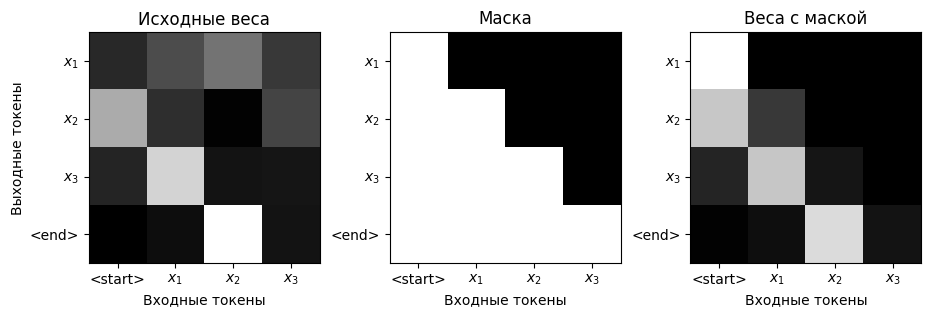

In [3]:
# токены предложения
tokens = ["<start>", r"$x_1$", r"$x_2$", r"$x_3$", "<end>"]
token_ids = torch.tensor([1, 3, 4, 5, 2])
input_ids = token_ids[:-1].view(1, -1)
target_ids = token_ids[1:].view(1, -1)

# создаём маску
causal_mask = create_causal_mask(target_ids)

# получаем эмбеддинги токенов (без позиционного кодирования для простоты)
embedding_layer = nn.Embedding(num_embeddings=7, embedding_dim=5)
h = embedding_layer.forward(token_ids.view(1, -1))

# внимание между входными и выходными токенами
attention = (
    torch.bmm(embedding_layer(input_ids), embedding_layer(target_ids).permute(0, 2, 1))
    / 5**0.5
)
# накладываем маску
masked_attention = attention.masked_fill(causal_mask == 0, float("-inf")).softmax(-1)


colormap = "gist_gray"
fig, axes = plt.subplots(1, 3, figsize=(11, 3))
axes[0].imshow(attention.squeeze().detach().softmax(-1), cmap=colormap)
axes[1].imshow(causal_mask.squeeze(), cmap=colormap)
axes[2].imshow(masked_attention.squeeze().detach(), cmap=colormap)

axes[0].set_ylabel("Выходные токены")
for ax, title in zip(axes, ["Исходные веса", "Маска", "Веса с маской"]):
    ax.set_title(title)
    ax.set_xlabel("Входные токены")
    ax.set_xticks(torch.arange(len(tokens) - 1), tokens[:-1])
    ax.set_yticks(torch.arange(len(tokens) - 1), tokens[1:])

plt.show()

In [4]:
class MaskedSelfAttention(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.W_q = nn.Linear(input_dim, hidden_dim)
        self.W_k = nn.Linear(input_dim, hidden_dim)
        self.W_v = nn.Linear(input_dim, input_dim)

    def forward(self, x: Tensor, mask: Tensor) -> Tensor:
        q = self.W_q(x)
        k = self.W_k(x)
        v = self.W_v(x)
        _, _, D_k = k.shape

        attention: Tensor = torch.bmm(q, k.permute(0, 2, 1)) / D_k**0.5
        # apply mask
        if mask is not None:
            attention = attention.masked_fill(mask == 0, float("-inf"))
        attention_weights = attention.softmax(-1)
        return torch.bmm(attention_weights, v)


MaskedSelfAttention(5, 3).forward(
    embedding_layer(input_ids), mask=create_causal_mask(input_ids)
).shape

torch.Size([1, 4, 5])

### 3. Encoder-decoder и перекрёстное внимание

Энкодер обрабатывает входной контекст, предоставляя надбор ключей и значений для декодера.

Декодер, помимо *masked self-attention*, теперь имеет второе внимание, направленное на контекст из энкодера — *cross-attention*

<img src="../assets/images/seq2seq.png" style="background:white" width="600"/>
<img src="../assets/images/cross-attention.png" style="background:white" width="174"/>

In [5]:
class MaskedAttention(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.W_q = nn.Linear(input_dim, hidden_dim)
        self.W_k = nn.Linear(input_dim, hidden_dim)
        self.W_v = nn.Linear(input_dim, input_dim)

    def forward(
        self, q: Tensor,
        k: Tensor,
        v: Tensor,
        mask: Tensor
    ) -> Tensor:
        q = self.W_q(q)
        k = self.W_k(k)
        v = self.W_v(v)
        _, _, D_k = k.shape
        attention: Tensor = torch.bmm(
            q, k.permute(0, 2, 1)
        ) / D_k**0.5
        # apply mask
        attention = attention.masked_fill(
            mask == 0, float("-inf")
        )
        attention_weights = attention.softmax(-1)
        return torch.bmm(attention_weights, v)


class DecoderLayer(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int) -> None:
        super().__init__()
        self.self_attention = MaskedAttention(input_dim, hidden_dim)
        self.cross_attention = MaskedAttention(input_dim, hidden_dim)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, input_dim),
            nn.ReLU(inplace=True),
            nn.Linear(input_dim, input_dim),
        )
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.norm3 = nn.LayerNorm(input_dim)

    def forward(
        self, x: Tensor,
        x_mask: Tensor,
        z: Tensor,
        z_mask: Tensor
    ) -> Tensor:
        # x — embedded targets
        # z — embedded inputs
        # 1. masked self-attention
        h = self.norm1(self.self_attention.forward(
            q=x, k=x, v=x, mask=x_mask) + x
        )
        # 2. cross-attention
        h = self.norm1(self.cross_attention.forward(
            q=h, k=z, v=z, mask=z_mask) + x
        )
        # 3. cross-attention
        return self.norm3(self.mlp(h) + h)

DecoderLayer(32, 32).forward(torch.randn(4, 12, 32), torch.ones(4, 1, 12), torch.randn(4, 10, 32), torch.ones(4, 1, 10)).shape

torch.Size([4, 12, 32])

In [6]:
x = torch.randn(4, 12, 32)
mask = torch.ones(4, 1, 12)
z = torch.randn(4, 10, 32)
z_mask = torch.ones(4, 1, 10)
print(MaskedAttention(32, 32).forward(x, x, x, mask).shape)
print(MaskedAttention(32, 32).forward(x, z, z, z_mask).shape)

torch.Size([4, 12, 32])
torch.Size([4, 12, 32])


Посмотрим на реализацию этого типа архитектуры на примере модели `T5` из библиотеки `transformers`.

`T5Block` — основной строительный блок как энкодера, так и декодера.

В энкодере он принимает эмбеддинги токенов `hidden_states` с предыдущего блока и маску для внимания `attention_mask` — она скрывает `<pad>` токены.

В декодере помимо эмбеддингов токенов `hidden_states` и маски `attention_mask` (она теперь также скрывает будущие токены) блоку нужно два дополнительных входа: эмбеддинги из энкодера `encoder_hidden_states` и соответствующую маску внимания `encoder_attention_mask`.

**Упражнение**. В T5 есть несколько модификаций по сравнению с архитектурой оригинального трансформера. В частности, эмбеддинг позиции токена теперь не абсолютный, а относительный. Разберите код класса `transformers.models.t5.modeling_t5.T5Attention`, чтобы понять, как это работает.

In [7]:
from transformers.models.t5.modeling_t5 import T5Block

### 4. Мультимодальные трансформеры

В токены можно превращать что угодно: фрагменты изображения, участки аудиофайлов, атомы молекул

А значит, можно даже передавать в трансформер токены, полученные и из разных модальностей

Примеры задач:
- ответы на вопросы по картинке
- суммаризация видео
- speech-to-speech между языками

<img src="../assets/images/vit.png" style="background:white" width="500"/>